# KTRX Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXFull, KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.estimators.stan_estimator import StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use("fivethirtyeight")

In [4]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [5]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [6]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [7]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTRLite

In [8]:
# level_knot_dates = pd.date_range(start='1981-01-01', end='1990-12-31', periods=21)
# level_knot_dates

In [9]:
ktrlite = KTRLiteMAP(response_col=RESPONSE_COL,
                     date_col=DATE_COL,
                     # seasonality
                     seasonality=[52],
                     seasonality_fs_order=[3],
                     level_knot_scale=.1,
                     span_level=.05,
                     # level_knot_dates=level_knot_dates,
                     # date_freq='D',
                     span_coefficients=.3,
                     estimator_type=StanEstimatorMAP,
                     n_bootstrap_draws=1e4)

In [10]:
ktrlite.fit(train_df)

In [11]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)

predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.21151,12.35675,12.50032,12.35965,12.37143,12.38287,-0.01467,-0.01467,-0.01467
1,2017-07-09,12.20413,12.35403,12.50467,12.34788,12.37143,12.39431,-0.01740,-0.01740,-0.01740
2,2017-07-16,12.19514,12.34744,12.49516,12.33610,12.37143,12.40576,-0.02398,-0.02398,-0.02398
3,2017-07-23,12.18443,12.33659,12.48785,12.32433,12.37143,12.41720,-0.03484,-0.03484,-0.03484
4,2017-07-30,12.16159,12.32134,12.48069,12.31255,12.37143,12.42864,-0.05009,-0.05009,-0.05009


In [12]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.75%'

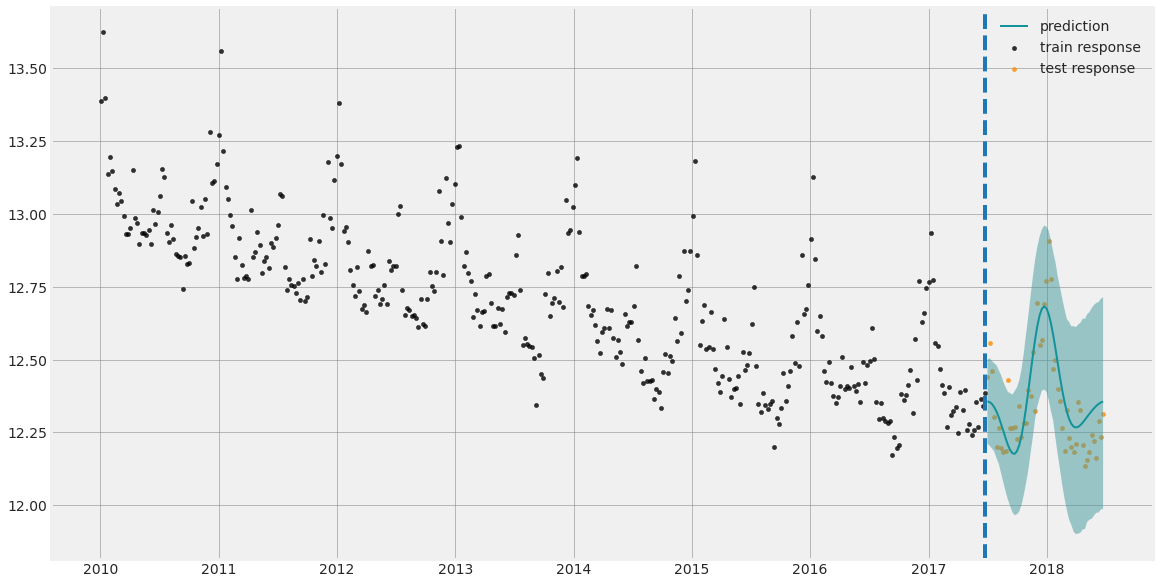

In [13]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/diagnostics/plot.py:218: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


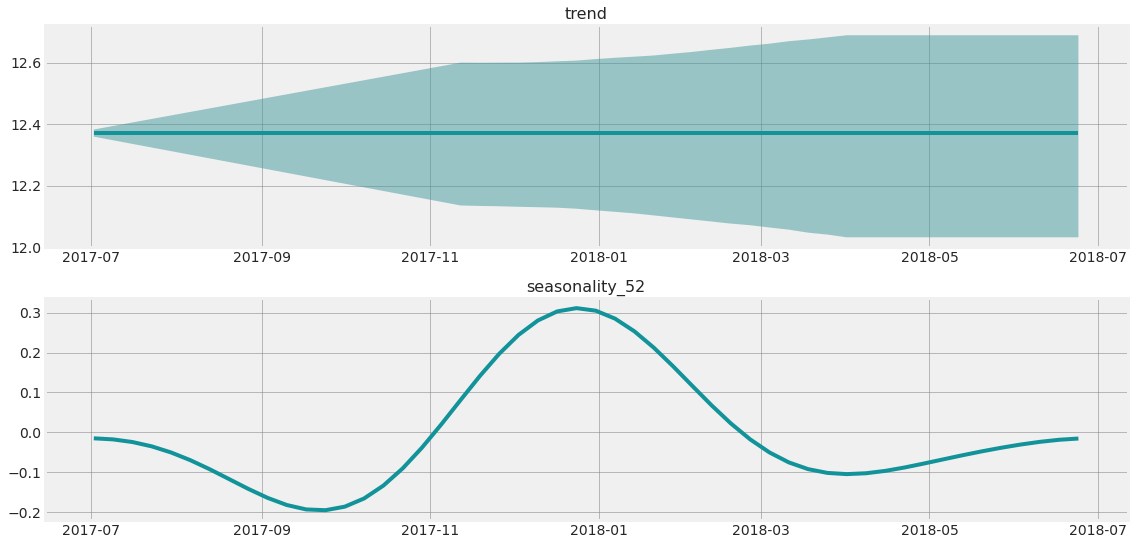

In [14]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_52'])

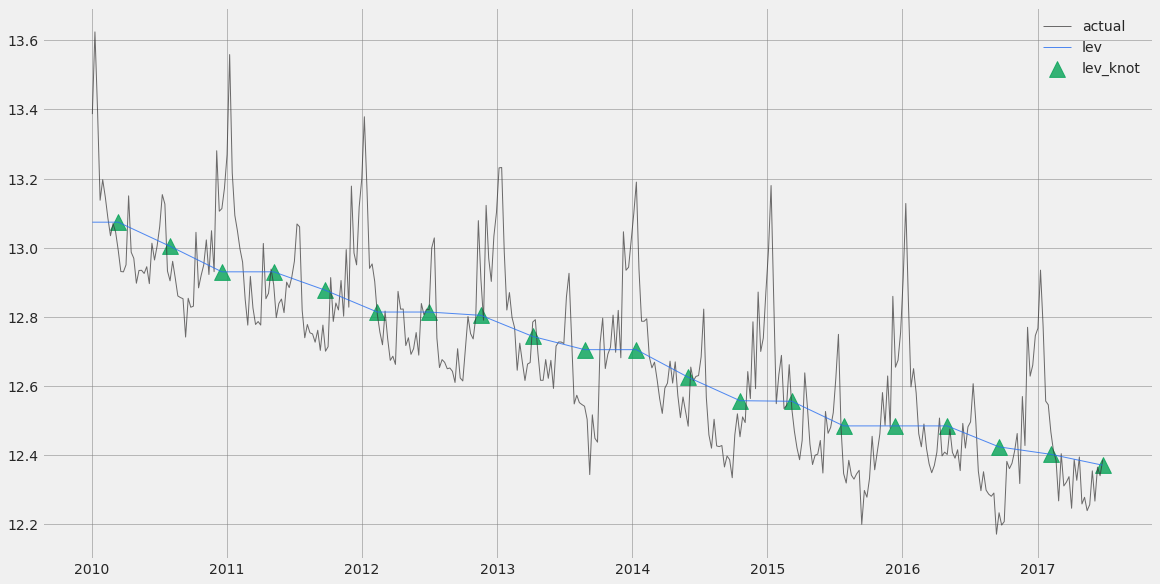

In [15]:
_ = ktrlite.plot_lev_knots()

## KTRX

In [16]:
# prepare the input
level_knot_dates = ktrlite._level_knot_dates

level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]

seasonal_knots_input = {'_seas_coef_knot_dates': ktrlite._coef_knot_dates,
                        '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
                        '_seasonality': ktrlite._seasonality,
                        '_seasonality_fs_order': ktrlite._seasonality_fs_order}

In [17]:
ktrx = KTRXAggregated(response_col=RESPONSE_COL,
                      date_col=DATE_COL,
                      level_knot_dates=level_knot_dates,
                      level_knots=level_knots,
                      seasonal_knots_input=seasonal_knots_input,
                      regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
                      level_knot_scale=.1, #.01
                      span_coefficients=0.3,
                      rho_coefficients=0.15,
                      # pyro optimization parameters
                      seed=8888,
                      num_steps=1000,
                      num_sample=1000,
                      learning_rate=0.1,
                      #learning_rate_total_decay=0.05,
                      verbose=True,
                      message=100,
                      aggregate_method="median",
                      estimator_type=PyroEstimatorVI)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = -69.329, scale = 0.088188
step  100 loss = -117.08, scale = 0.2215
step  200 loss = -116.92, scale = 0.21604
step  300 loss = -116.77, scale = 0.21498
step  400 loss = -117.35, scale = 0.21914
step  500 loss = -117.18, scale = 0.21388
step  600 loss = -117.21, scale = 0.22391
step  700 loss = -117.12, scale = 0.20775
step  800 loss = -117.46, scale = 0.20408
step  900 loss = -116.33, scale = 0.22731


In [18]:
# ktrx = KTRXFull(
#     response_col=response_col,
#     date_col=date_col,
#     level_knot_dates=level_knot_dates,
#     level_knots=level_knots,
#     seasonal_knots_input=seasonal_knots_input,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
#     level_knot_scale=.1, #.01
#     span_coefficients=0.3,
#     rho_coefficients=0.15,
#     # pyro optimization parameters
#     seed=8888,
#     num_steps=1000,
#     num_sample=1000,
#     learning_rate=0.1,
#     #learning_rate_total_decay=0.05,
#     verbose=True,
#     message=100,
#     estimator_type=PyroEstimatorVI,
# )

# ktrx.fit(train_df)

In [19]:
coef_df = ktrx.get_regression_coefs(coefficient_method="smooth") # include_ci=True

print(coef_df.head())
print(coef_df.tail())

        week  trend.unemploy  trend.filling  trend.job
0 2010-01-03         0.08888        0.10323    0.21096
1 2010-01-10         0.08887        0.10324    0.21096
2 2010-01-17         0.08886        0.10324    0.21096
3 2010-01-24         0.08885        0.10325    0.21097
4 2010-01-31         0.08884        0.10326    0.21097
          week  trend.unemploy  trend.filling  trend.job
386 2017-05-28         0.05873        0.11888    0.25222
387 2017-06-04         0.05873        0.11888    0.25223
388 2017-06-11         0.05873        0.11887    0.25224
389 2017-06-18         0.05874        0.11887    0.25226
390 2017-06-25         0.05874        0.11886    0.25227


In [20]:
coef_df = ktrx.get_regression_coefs(coefficient_method="empirical") # include_ci=True

print(coef_df.head())
print(coef_df.tail())

        week  trend.unemploy  trend.filling  trend.job
0 2010-01-03         0.08906        0.10378    0.21017
1 2010-01-10         0.08905        0.10382    0.21013
2 2010-01-17         0.08904        0.10386    0.21009
3 2010-01-24         0.08903        0.10390    0.21005
4 2010-01-31         0.08902        0.10394    0.21001
          week  trend.unemploy  trend.filling  trend.job
386 2017-05-28         0.05917        0.11838    0.25316
387 2017-06-04         0.05916        0.11841    0.25311
388 2017-06-11         0.05914        0.11845    0.25306
389 2017-06-18         0.05912        0.11848    0.25301
390 2017-06-25         0.05910        0.11851    0.25296


In [21]:
coef_df = ktrx.get_regression_coefs(coefficient_method="smooth" ,
                                    date_array=['2017-06-11', '2017-06-18', '2017-06-25',
                                                '2017-07-02', '2017-07-09', '2017-07-16']) 
coef_df

,week,trend.unemploy,trend.filling,trend.job
0,2017-06-11,0.05873,0.11887,0.25224
1,2017-06-18,0.05874,0.11887,0.25226
2,2017-06-25,0.05874,0.11886,0.25227
3,2017-07-02,0.05874,0.11886,0.25227
4,2017-07-09,0.05874,0.11886,0.25227
5,2017-07-16,0.05874,0.11886,0.25227


In [22]:
coef_df = ktrx.get_regression_coefs(coefficient_method="empirical" ,
                                    date_array=['2017-06-11', '2017-06-18', '2017-06-25',
                                                '2017-07-02', '2017-07-09', '2017-07-16']) 
coef_df

,week,trend.unemploy,trend.filling,trend.job
0,2017-06-11,0.05914,0.11845,0.25306
1,2017-06-18,0.05912,0.11848,0.25301
2,2017-06-25,0.05910,0.11851,0.25296
3,2017-07-02,0.05910,0.11851,0.25296
4,2017-07-09,0.05910,0.11851,0.25296
5,2017-07-16,0.05910,0.11851,0.25296


/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


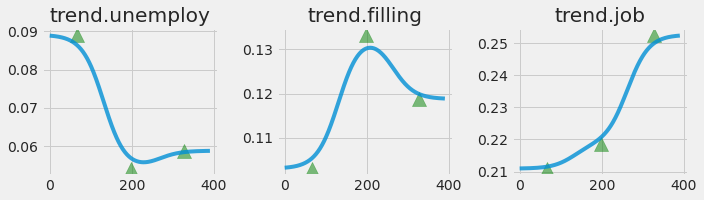

In [23]:
_ = ktrx.plot_regression_coefs(with_knot=True, coefficient_method='smooth', ncol=3, figsize=(10, 3))

In [24]:
predicted_df = ktrx.predict(df=test_df, coefficient_method="smooth", decompose=False)

predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,11.88883,12.33372,12.77331
1,2017-07-09,11.89803,12.35194,12.80572
2,2017-07-16,11.88733,12.33697,12.78118
3,2017-07-23,11.87755,12.32964,12.77217
4,2017-07-30,11.86829,12.32331,12.77843


In [26]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.75%'

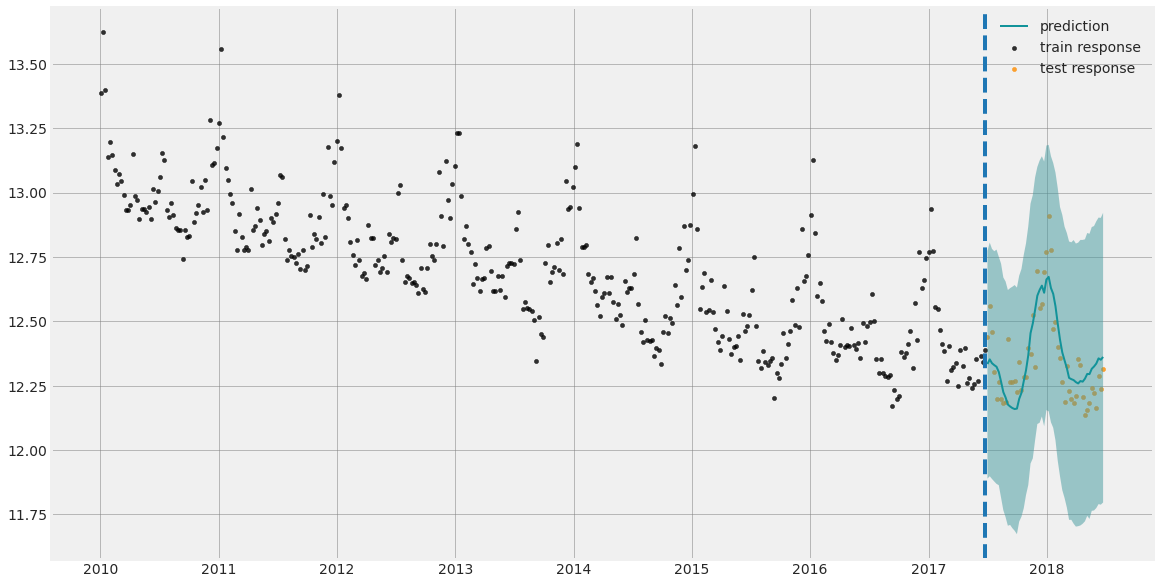

In [27]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

In [28]:
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,11.88883,12.33372,12.77331
1,2017-07-09,11.89803,12.35194,12.80572
2,2017-07-16,11.88733,12.33697,12.78118
3,2017-07-23,11.87755,12.32964,12.77217
4,2017-07-30,11.86829,12.32331,12.77843


In [29]:
# ## In dev, currently predict method does not return appropriate structure in order
# ## plot_predicted_components to work


# _ = plot_predicted_components(predicted_df=predicted_df,
#                               date_col=date_col,
#                               plot_components=['trend', 'seasonality_input', 'regression'])

## Try a different data

In [30]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [31]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [32]:
ktrlite = KTRLiteMAP(response_col=RESPONSE_COL,
                     date_col=DATE_COL,
                     # seasonality
                     seasonality=[7, 365.25],
                     seasonality_fs_order=[2, 5],
                     level_knot_scale=.1,
                     span_level=.05,
                     # level_knot_dates=level_knot_dates,
                     # date_freq='D',
                     span_coefficients=.3,
                     estimator_type=StanEstimatorMAP,
                     n_bootstrap_draws=1e4)

ktrlite.fit(train_df)

In [33]:
# prepare the input
level_knot_dates = ktrlite._level_knot_dates

level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]

seasonal_knots_input = {'_seas_coef_knot_dates': ktrlite._coef_knot_dates,
                        '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
                        '_seasonality': ktrlite._seasonality,
                        '_seasonality_fs_order': ktrlite._seasonality_fs_order,
}

In [34]:
ktrx = KTRXFull(response_col=RESPONSE_COL,
                date_col=DATE_COL,
                level_knot_dates=level_knot_dates,
                level_knots=level_knots,
                seasonal_knots_input=seasonal_knots_input,
                level_knot_scale=.1, #.01
                span_coefficients=0.3,
                rho_coefficients=0.15,
                # pyro optimization parameters
                seed=8888,
                num_steps=1000,
                num_sample=1000,
                learning_rate=0.1,
                #learning_rate_total_decay=0.05,
                verbose=True,
                message=100,
                estimator_type=PyroEstimatorVI)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = -2029.6, scale = 0.081195
step  100 loss = -2414.4, scale = 0.24977
step  200 loss = -2412.9, scale = 0.23128
step  300 loss = -2416.8, scale = 0.25605
step  400 loss = -2412, scale = 0.24845
step  500 loss = -2413.2, scale = 0.23618
step  600 loss = -2409.8, scale = 0.2589
step  700 loss = -2415.9, scale = 0.24264
step  800 loss = -2413.2, scale = 0.25749
step  900 loss = -2411.8, scale = 0.25188


In [35]:
predicted_df = ktrx.predict(df=test_df, decompose=True)

predicted_df.head()

,date,prediction_5,prediction,prediction_95
0,2008-01-02,9.69134,9.98554,10.28596
1,2008-01-03,9.69751,9.99583,10.26163
2,2008-01-04,9.71741,10.00655,10.29545
3,2008-01-05,9.65367,9.93556,10.21836
4,2008-01-06,9.57373,9.86819,10.15533


In [37]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.57%'

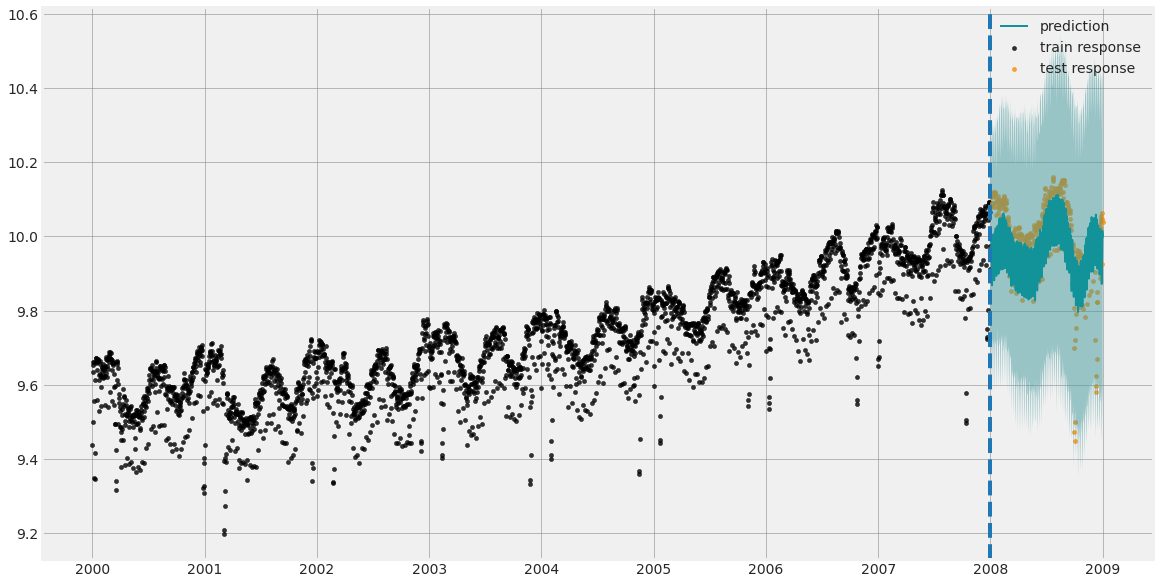

In [38]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)